# Covid19

In [5]:
# for data manipulation & linear algebrea
import pandas as pd
import numpy as np
pd.set_option("display.precision", 2)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import plotly
# import plotly.graph_objs as go
%config InlineBackend.figure_format = 'retina' # vs 'svg'/'png'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['image.cmap'] = 'viridis'

# for machine learning
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree

# Other libraries
import time
from datetime import datetime
import sys

sys.path.append('/Users/herve/code/hervelao/covid19-global-forecasting')

# Autoreload
%load_ext autoreload
%autoreload 2

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Import data
from covid19.data import COVID19

data = COVID19().get_data()

Memory usage of dataframe is 0.56 MB
Memory usage after optimization is: 0.14 MB
Decreased by 74.7%
Memory usage of dataframe is 0.28 MB
Memory usage after optimization is: 0.05 MB
Decreased by 83.3%
Memory usage of dataframe is 1.09 MB
Memory usage after optimization is: 0.31 MB
Decreased by 72.1%


## 1. Exploratory data analysis (EDA)

In [10]:
data.keys()

dict_keys(['test', 'submission', 'train'])

In [11]:
submission = data['submission']
test = data['test']
train = data['train']
display(train.head(5))
display(train.describe())
print("Number of Country/Region: ", train['Country/Region'].nunique())
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")
print("Countries with Province/State informed: ", train[train['Province/State'].isna()==False]['Country/Region'].unique())

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


,Id,Lat,Long,ConfirmedCases,Fatalities
count,17892.00,1.79e+04,1.79e+04,17892.00,17892.0
mean,13191.50,inf,inf,325.21,inf
std,7624.68,2.29e+01,7.99e+01,3538.00,inf
min,1.00,-4.15e+01,-1.58e+02,0.00,0.0
25%,6596.25,1.31e+01,-7.15e+01,0.00,0.0
50%,13191.50,3.30e+01,9.77e+00,0.00,0.0
75%,19786.75,4.25e+01,6.47e+01,10.00,0.0
max,26382.00,7.17e+01,1.75e+02,69176.00,6820.0


Number of Country/Region:  163
Dates go from day 2020-03-24 to day 2020-01-22 , a total of 63 days
Countries with Province/State informed:  [Australia, Canada, China, Cruise Ship, Denmark, France, Netherlands, US, United Kingdom]
Categories (9, object): [Australia, Canada, China, Cruise Ship, ..., France, Netherlands, US, United Kingdom]


Text(0.5, 0, 'Date')

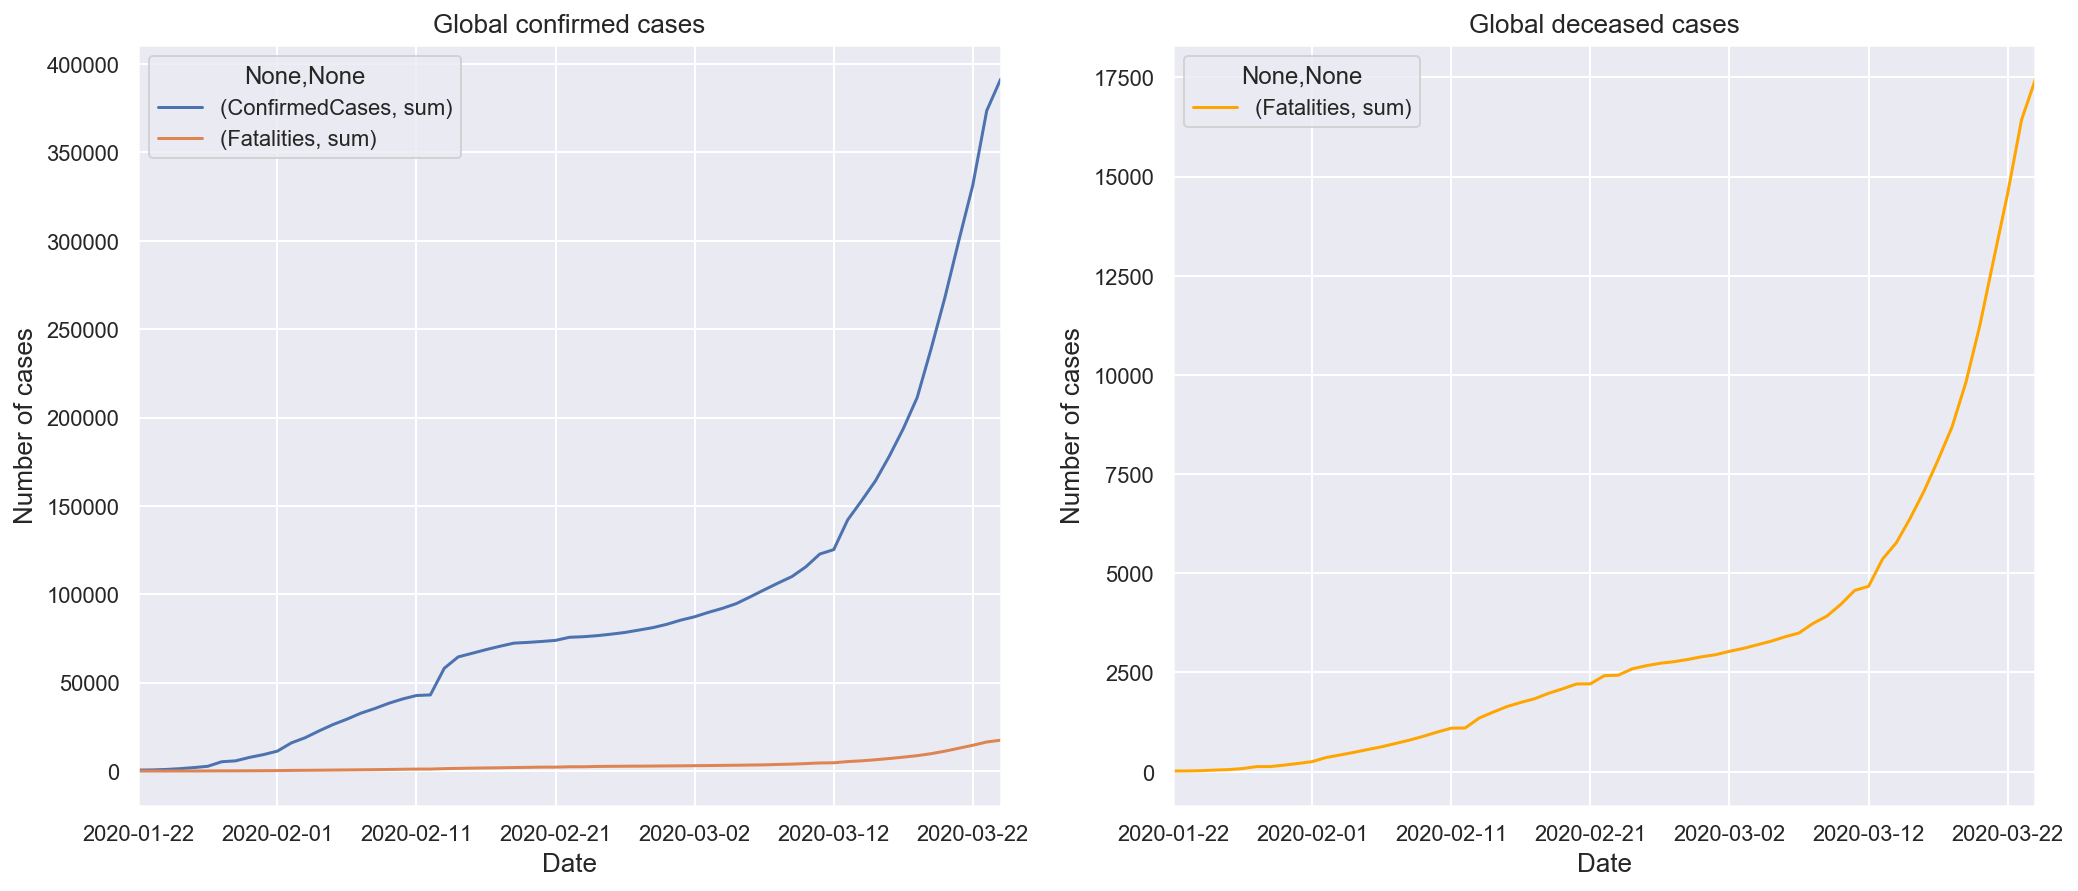

In [12]:
confirmed_country = train.groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country = train.groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))

total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)

fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

Text(0.5, 0, 'Date')

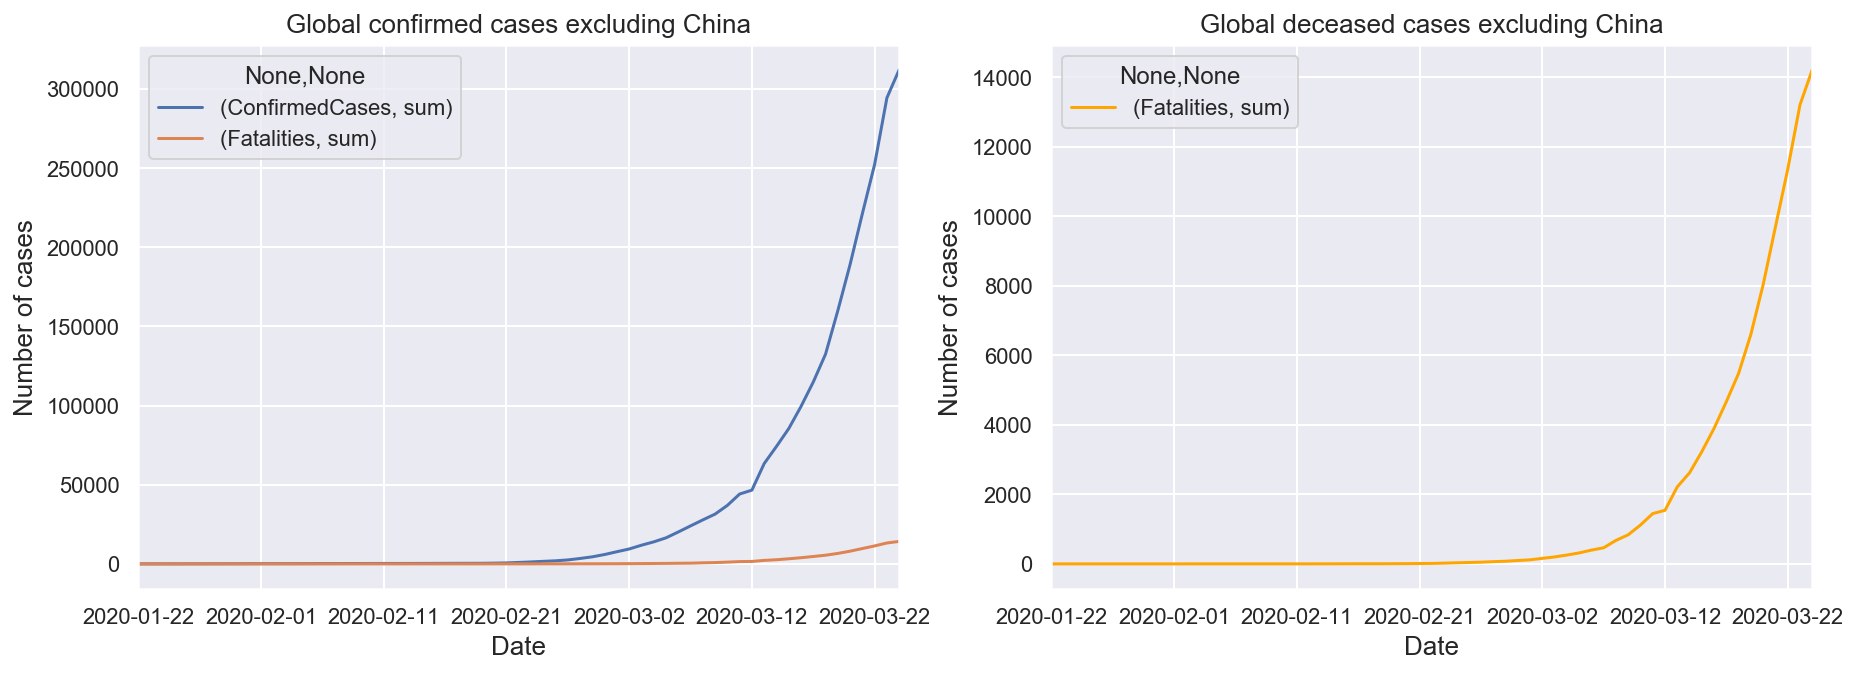

In [13]:
confirmed_country_noChina = train[train['Country/Region']!='China'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_noChina = train[train['Country/Region']!='China'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_noChina = train[train['Country/Region']!='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_noChina = train[train['Country/Region']!='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_noChina = confirmed_total_date_noChina.join(fatalities_total_date_noChina)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
total_date_noChina.plot(ax=ax1)
ax1.set_title("Global confirmed cases excluding China", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_noChina.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases excluding China", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

Text(0.5, 0, 'Date')

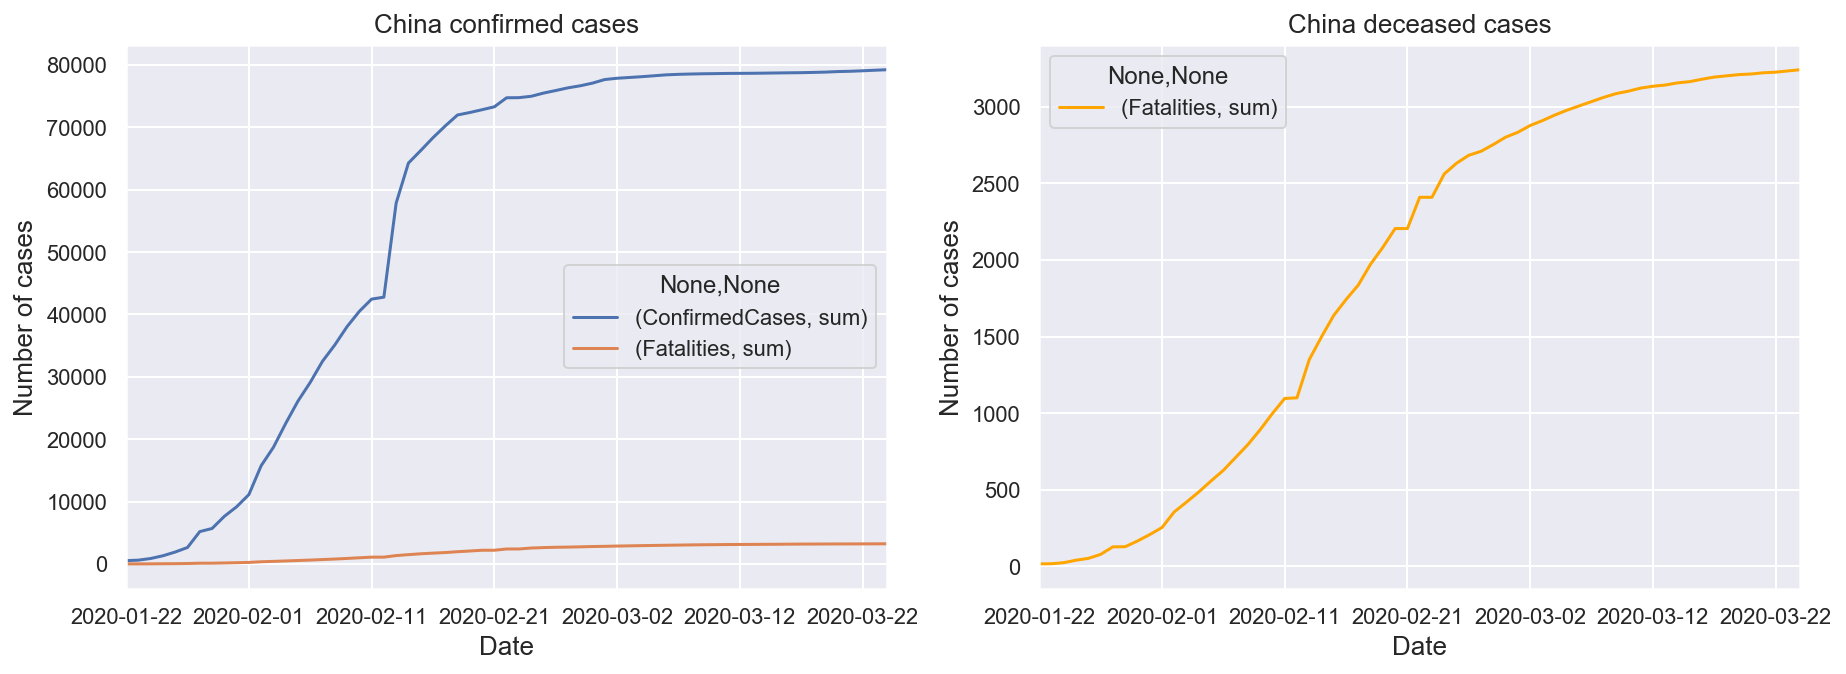

In [14]:
confirmed_country_China = train[train['Country/Region']=='China'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_China = train[train['Country/Region']=='China'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_China = train[train['Country/Region']=='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_China = train[train['Country/Region']=='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_China = confirmed_total_date_China.join(fatalities_total_date_China)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
total_date_China.plot(ax=ax1)
ax1.set_title("China confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_China.plot(ax=ax2, color='orange')
ax2.set_title("China deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

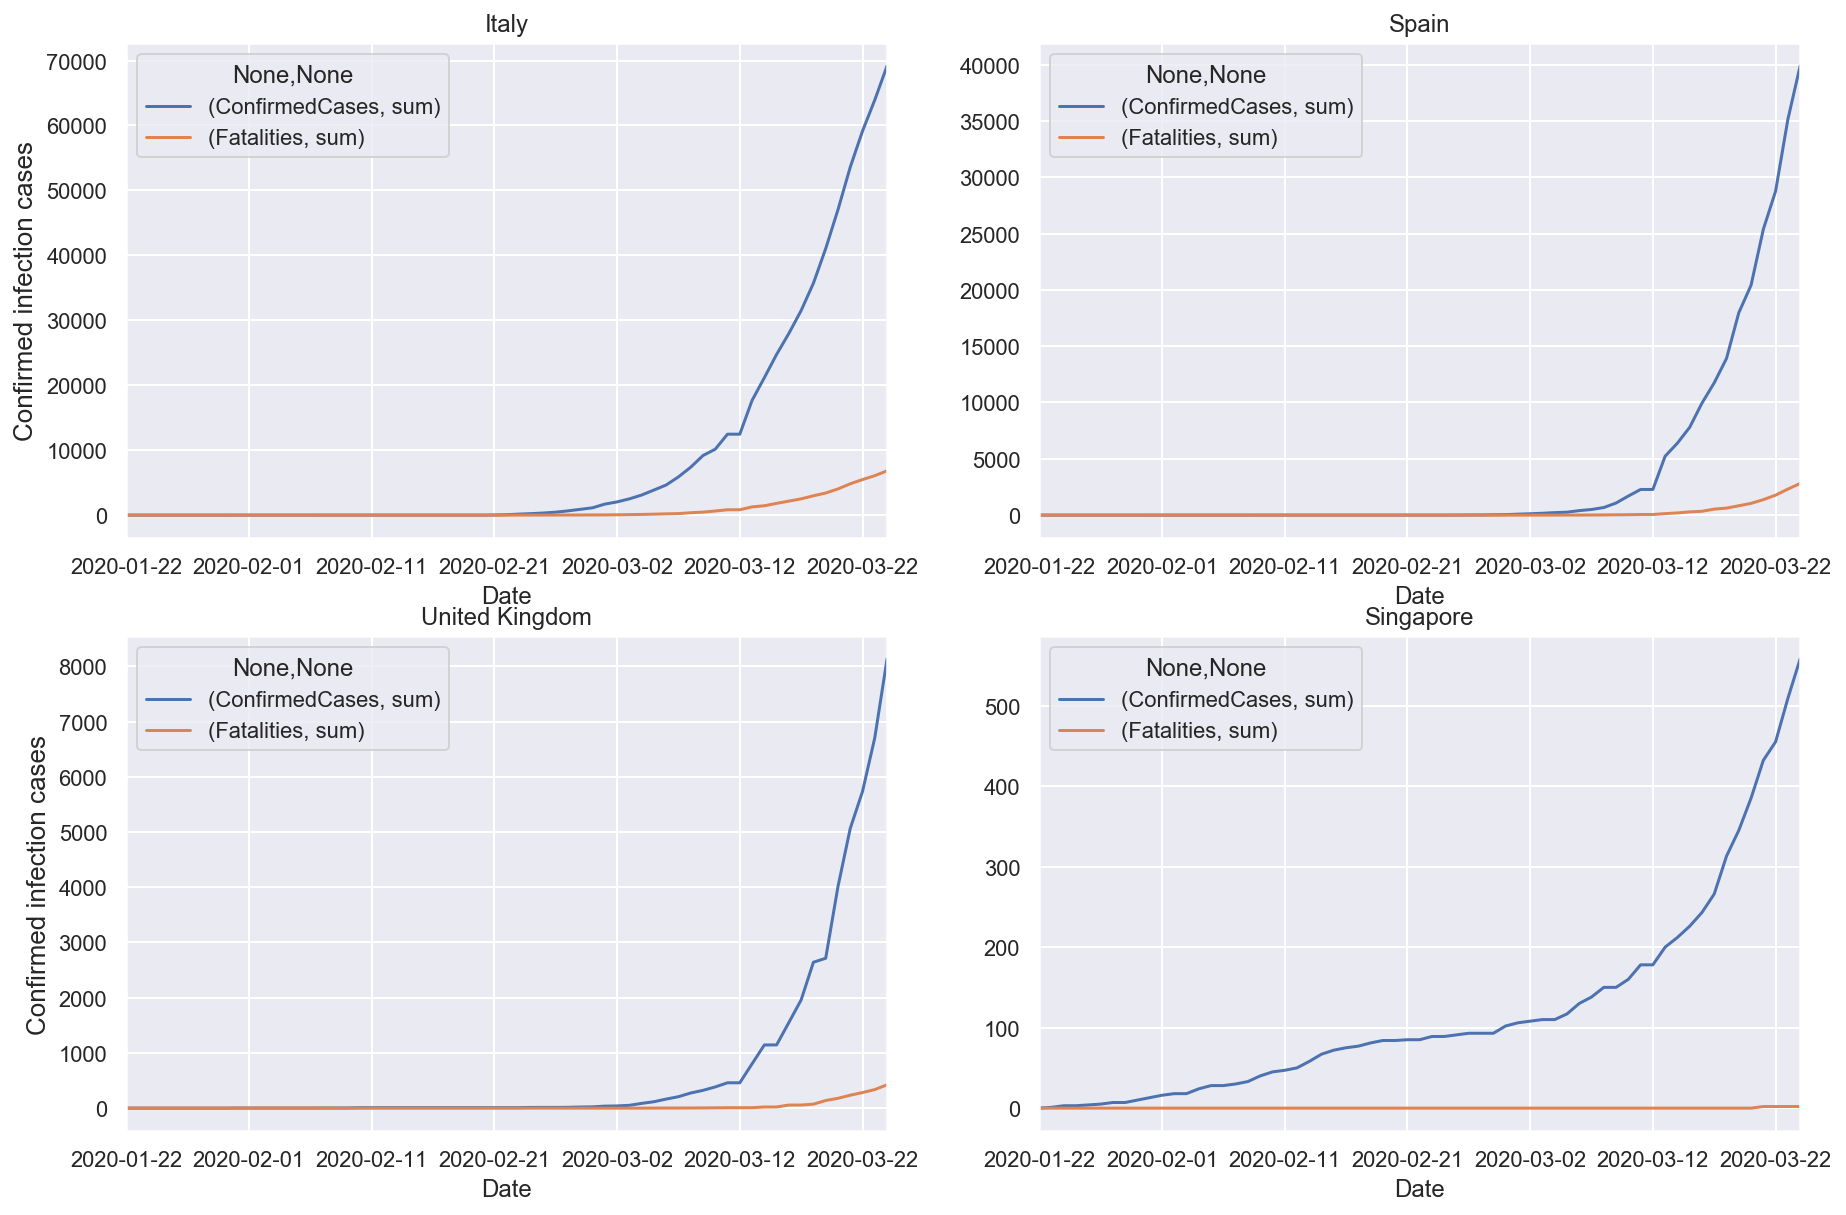

In [15]:
confirmed_country_Italy = train[train['Country/Region']=='Italy'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_Italy = train[train['Country/Region']=='Italy'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Italy = train[train['Country/Region']=='Italy'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[train['Country/Region']=='Italy'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

confirmed_country_Spain = train[train['Country/Region']=='Spain'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_Spain = train[train['Country/Region']=='Spain'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Spain = train[train['Country/Region']=='Spain'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[train['Country/Region']=='Spain'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

confirmed_country_UK = train[train['Country/Region']=='United Kingdom'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_UK = train[train['Country/Region']=='United Kingdom'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_UK = train[train['Country/Region']=='United Kingdom'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[train['Country/Region']=='United Kingdom'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)

confirmed_country_Australia = train[train['Country/Region']=='Australia'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_Australia = train[train['Country/Region']=='Australia'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Australia = train[train['Country/Region']=='Australia'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Australia = train[train['Country/Region']=='Australia'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Australia = confirmed_total_date_Australia.join(fatalities_total_date_Australia)

confirmed_country_Singapore = train[train['Country/Region']=='Singapore'].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_Singapore = train[train['Country/Region']=='Singapore'].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Singapore = train[train['Country/Region']=='Singapore'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Singapore = train[train['Country/Region']=='Singapore'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Singapore = confirmed_total_date_Singapore.join(fatalities_total_date_Singapore)

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_date_Italy.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 2)
total_date_Spain.plot(ax=plt.gca(), title='Spain')

plt.subplot(2, 2, 3)
total_date_UK.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 4)
total_date_Singapore.plot(ax=plt.gca(), title='Singapore')

(0, 0.005)

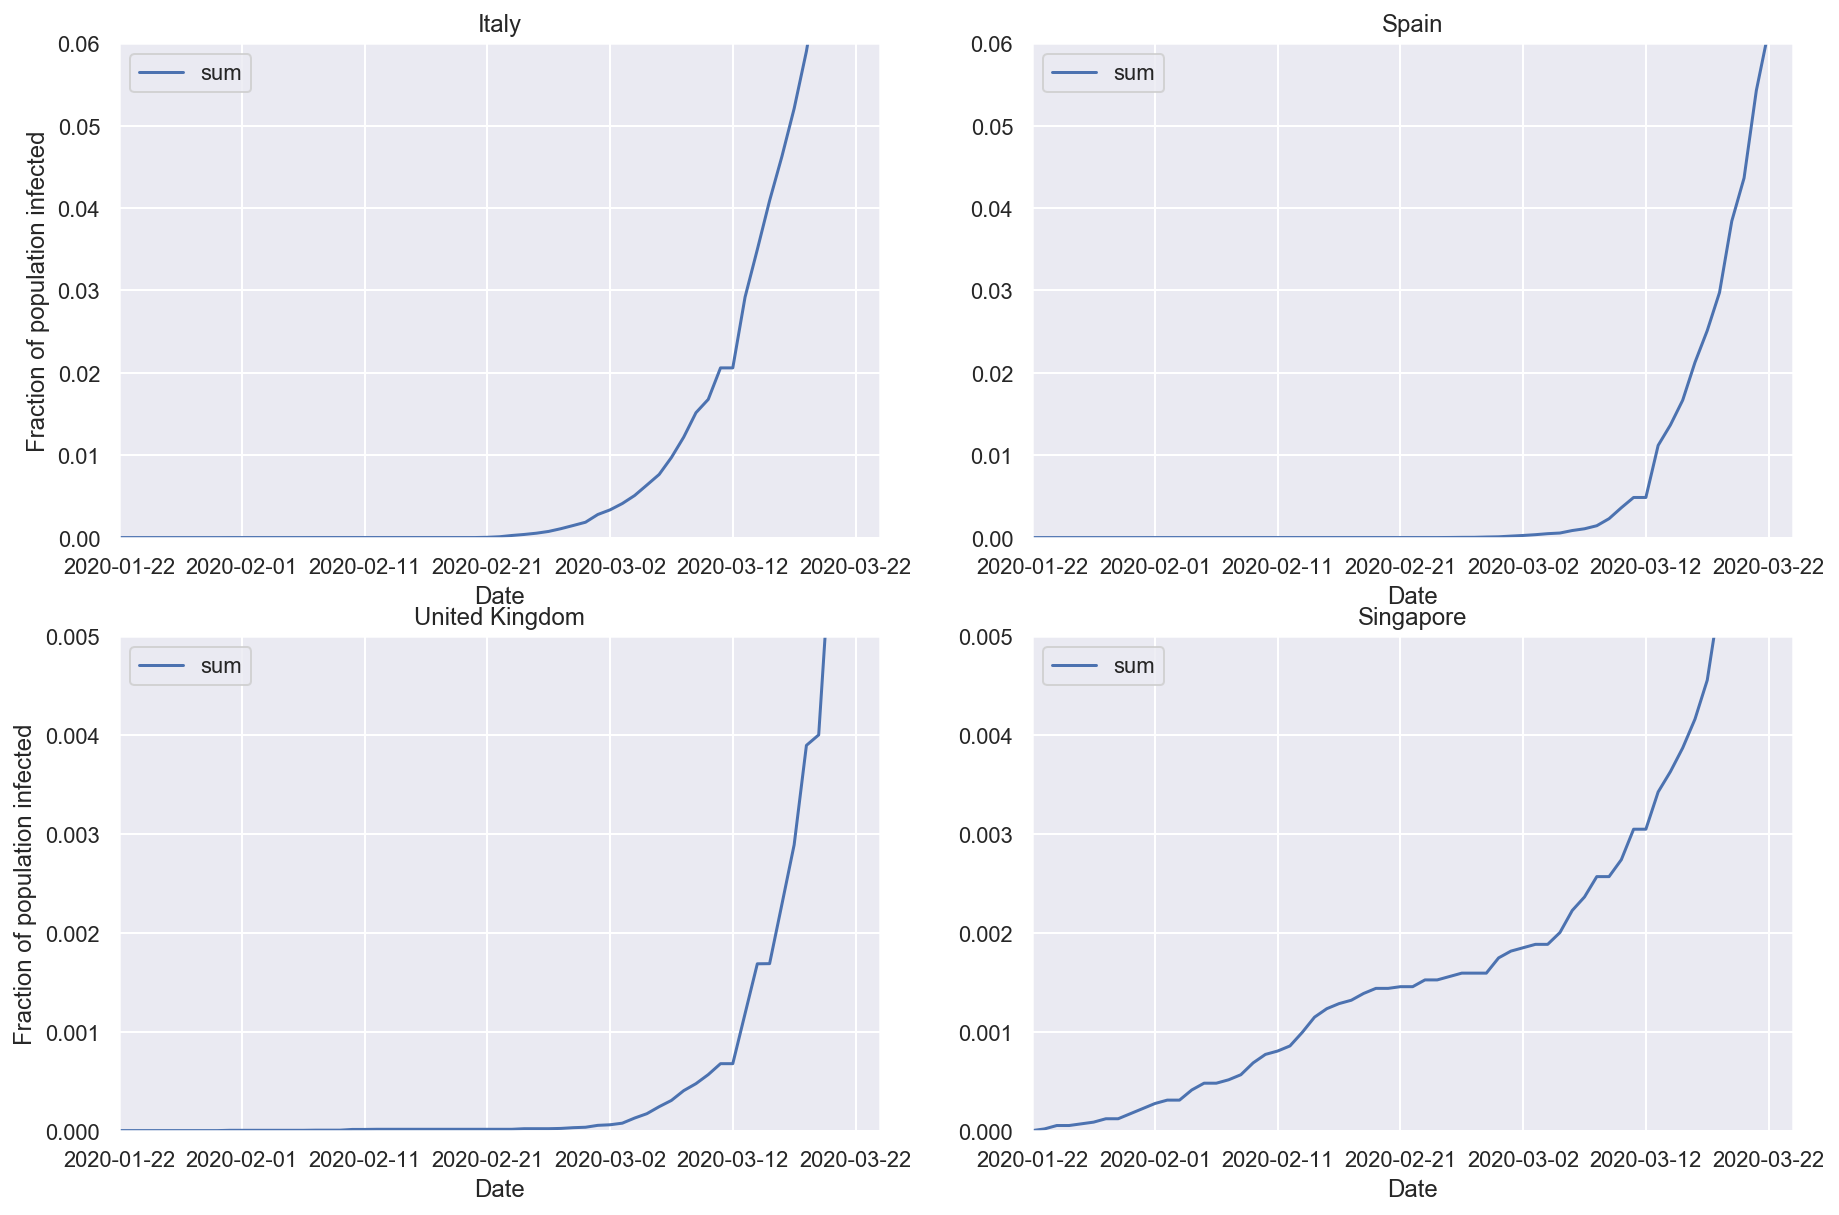

In [16]:
pop_italy = 60486683.
pop_spain = 46749696.
pop_UK = 67784927.
pop_singapore = 5837230.

total_date_Italy.ConfirmedCases = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Italy.Fatalities = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Spain.ConfirmedCases = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_Spain.Fatalities = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_UK.ConfirmedCases = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_UK.Fatalities = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_Singapore.ConfirmedCases = total_date_Singapore.ConfirmedCases/pop_singapore*100.
total_date_Singapore.Fatalities = total_date_Singapore.ConfirmedCases/pop_singapore*100.

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_date_Italy.ConfirmedCases.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.06)

plt.subplot(2, 2, 2)
total_date_Spain.ConfirmedCases.plot(ax=plt.gca(), title='Spain')
plt.ylim(0, 0.06)

plt.subplot(2, 2, 3)
total_date_UK.ConfirmedCases.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.005)

plt.subplot(2, 2, 4)
total_date_Singapore.ConfirmedCases.plot(ax=plt.gca(), title='Singapore')
plt.ylim(0, 0.005)

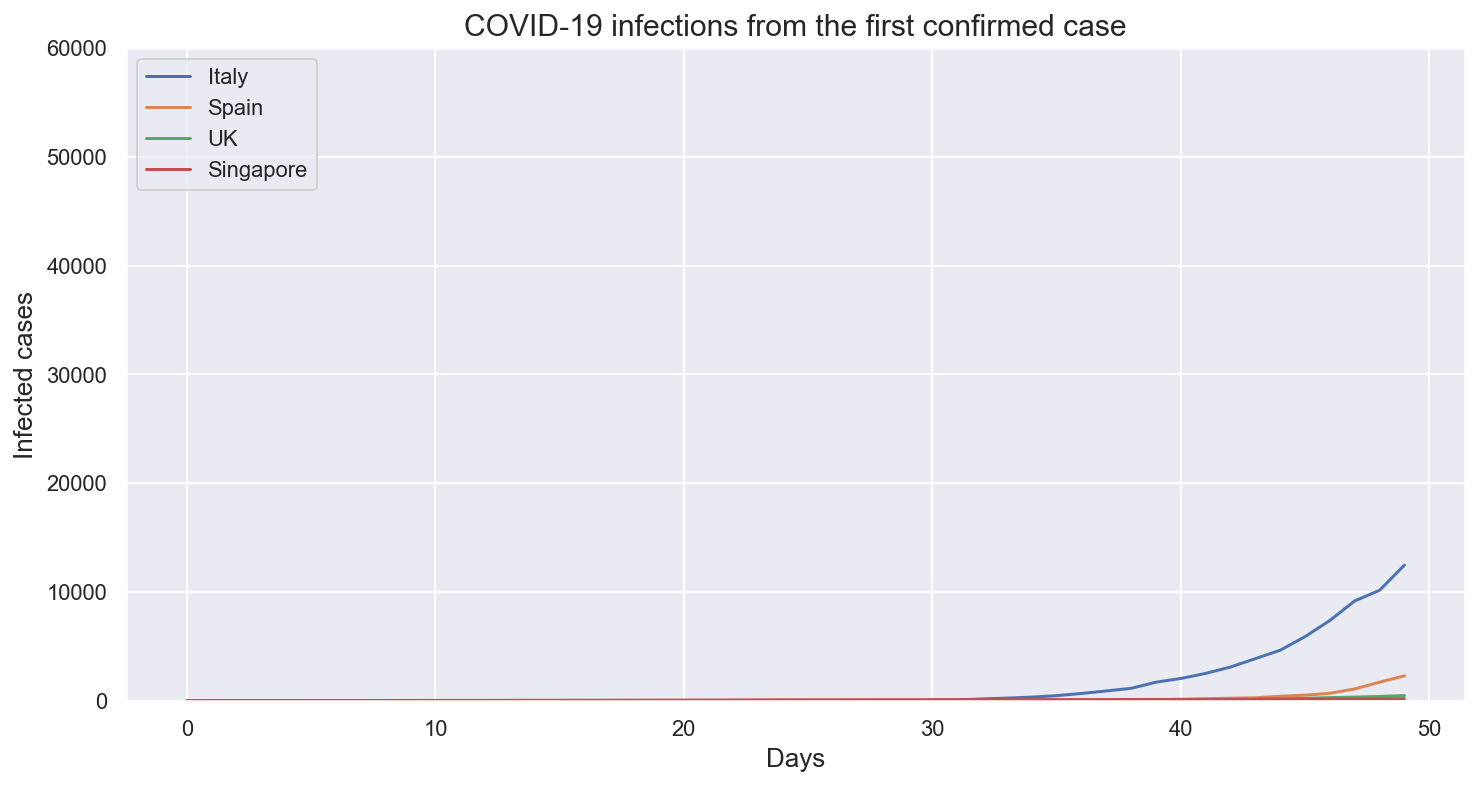

In [18]:
confirmed_country_Italy = train[(train['Country/Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_Italy = train[(train['Country/Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Italy = train[(train['Country/Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[(train['Country/Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

confirmed_country_Spain = train[(train['Country/Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_Spain = train[(train['Country/Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Spain = train[(train['Country/Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[(train['Country/Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

confirmed_country_UK = train[(train['Country/Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_UK = train[(train['Country/Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_UK = train[(train['Country/Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[(train['Country/Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)

confirmed_country_Australia = train[(train['Country/Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_Australia = train[(train['Country/Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Australia = train[(train['Country/Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Australia = train[(train['Country/Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Australia = confirmed_total_date_Australia.join(fatalities_total_date_Australia)

confirmed_country_Singapore = train[(train['Country/Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
fatalities_country_Singapore = train[(train['Country/Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date_Singapore = train[(train['Country/Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Singapore = train[(train['Country/Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Singapore = confirmed_total_date_Singapore.join(fatalities_total_date_Singapore)

italy = [i for i in total_date_Italy.ConfirmedCases['sum'].values]
italy_30 = italy[0:50] 
spain = [i for i in total_date_Spain.ConfirmedCases['sum'].values]
spain_30 = spain[0:50] 
UK = [i for i in total_date_UK.ConfirmedCases['sum'].values]
UK_30 = UK[0:50] 
singapore = [i for i in total_date_Singapore.ConfirmedCases['sum'].values]
singapore_30 = singapore[0:50] 


# Plots
plt.figure(figsize=(12,6))
plt.plot(italy_30)
plt.plot(spain_30)
plt.plot(UK_30)
plt.plot(singapore_30)
plt.legend(["Italy", "Spain", "UK", "Singapore"], loc='upper left')
plt.title("COVID-19 infections from the first confirmed case", size=15)
plt.xlabel("Days", size=13)
plt.ylabel("Infected cases", size=13)
plt.ylim(0, 60000)
plt.show()

## 2. Data enrichment

In [25]:
# Merge train and test, exclude overlap
dates_overlap = ['2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23']
train2 = train.loc[~train['Date'].isin(dates_overlap)]
all_data = pd.concat([train2, test], axis = 0, sort=False)

# Double check that there are no informed ConfirmedCases and Fatalities after 2020-03-11
all_data.loc[all_data['Date'] >= '2020-03-12', 'ConfirmedCases'] = np.nan
all_data.loc[all_data['Date'] >= '2020-03-12', 'Fatalities'] = np.nan
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

# Fill null values given that we merged train-test datasets
all_data['Province/State'] = all_data['Province/State'].cat.add_categories('None')
all_data['Province/State'].fillna("None", inplace=True)
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['Fatalities'].fillna(0, inplace=True)
all_data['Id'].fillna(-1, inplace=True)
all_data['ForecastId'].fillna(-1, inplace=True)

# Aruba has no Lat nor Long. Inform it manually
all_data.loc[all_data['Lat'].isna()==True, 'Lat'] = 12.510052
all_data.loc[all_data['Long'].isna()==True, 'Long'] = -70.009354

display(all_data)
display(all_data.loc[all_data['Date'] == '2020-03-12'])

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,1.0,None,Afghanistan,33.00,65.00,2020-01-22,0.0,0.0,-1.0,0,22,1,2020
1,2.0,None,Afghanistan,33.00,65.00,2020-01-23,0.0,0.0,-1.0,1,23,1,2020
2,3.0,None,Afghanistan,33.00,65.00,2020-01-24,0.0,0.0,-1.0,2,24,1,2020
3,4.0,None,Afghanistan,33.00,65.00,2020-01-25,0.0,0.0,-1.0,3,25,1,2020
4,5.0,None,Afghanistan,33.00,65.00,2020-01-26,0.0,0.0,-1.0,4,26,1,2020
5,6.0,None,Afghanistan,33.00,65.00,2020-01-27,0.0,0.0,-1.0,5,27,1,2020
6,7.0,None,Afghanistan,33.00,65.00,2020-01-28,0.0,0.0,-1.0,6,28,1,2020
7,8.0,None,Afghanistan,33.00,65.00,2020-01-29,0.0,0.0,-1.0,7,29,1,2020
8,9.0,None,Afghanistan,33.00,65.00,2020-01-30,0.0,0.0,-1.0,8,30,1,2020
9,10.0,None,Afghanistan,33.00,65.00,2020-01-31,0.0,0.0,-1.0,9,31,1,2020


,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,-1.0,None,Afghanistan,33.00,65.00,2020-03-12,0.0,0.0,1.0,50,12,3,2020
43,-1.0,None,Albania,41.16,20.17,2020-03-12,0.0,0.0,44.0,50,12,3,2020
86,-1.0,None,Algeria,28.03,1.66,2020-03-12,0.0,0.0,87.0,50,12,3,2020
129,-1.0,None,Andorra,42.50,1.52,2020-03-12,0.0,0.0,130.0,50,12,3,2020
172,-1.0,None,Antigua and Barbuda,17.06,-61.78,2020-03-12,0.0,0.0,173.0,50,12,3,2020
215,-1.0,None,Argentina,-38.41,-63.62,2020-03-12,0.0,0.0,216.0,50,12,3,2020
258,-1.0,None,Armenia,40.06,45.03,2020-03-12,0.0,0.0,259.0,50,12,3,2020
301,-1.0,None,Aruba,12.52,-69.94,2020-03-12,0.0,0.0,302.0,50,12,3,2020
344,-1.0,Australian Capital Territory,Australia,-35.47,149.00,2020-03-12,0.0,0.0,345.0,50,12,3,2020
387,-1.0,From Diamond Princess,Australia,35.44,139.62,2020-03-12,0.0,0.0,388.0,50,12,3,2020


In [26]:
missings_count = {col:all_data[col].isnull().sum() for col in all_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                0
Id              0
Province/State  0
Country/Region  0
Lat             0
Long            0
Date            0
ConfirmedCases  0
Fatalities      0
ForecastId      0
Day_num         0
Day             0
Month           0
Year            0


In [28]:
def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df[column]-df[column].shift(lag, fill_value=-999))/df[column].shift(lag, fill_value=0)
    return df


def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df[column].shift(lag, fill_value=0)
    return df

In [ ]:
ts = time.time()
all_data = calculate_lag(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_lag(all_data, range(1,7), 'Fatalities')
all_data = calculate_trend(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_trend(all_data, range(1,7), 'Fatalities')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)